# Figures

## Import packages.

In [1]:
import graphviz as gv
import numpy    as np
import pandas   as pd
import re       as re
import seaborn  as sb

from sklearn                 import svm
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LinearRegression, LogisticRegression
from sklearn.metrics         import confusion_matrix, explained_variance_score, make_scorer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neural_network  import MLPClassifier, MLPRegressor
from sklearn.preprocessing   import MinMaxScaler
from sklearn.tree            import DecisionTreeClassifier, plot_tree

from IPython.display import display

## Descriptive plots.

### Define nonlinear scales.

In [2]:
import matplotlib.scale      as mscale
import matplotlib.pyplot     as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker     as ticker

class SquareRootScale(mscale.ScaleBase):

    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)


class ArctangentScale(mscale.ScaleBase):
    name = 'arctangent'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return vmin, vmax

    class ArctangentTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.arctan(np.array(a)) * 2 / np.pi

        def inverted(self):
            return ArctangentScale.InvertedArctangentTransform()

    class InvertedArctangentTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.tan(np.array(a) * np.pi / 2)

        def inverted(self):
            return ArctangentScale.ArctangentTransform()

    def get_transform(self):
        return self.ArctangentTransform()

mscale.register_scale(ArctangentScale)

### Load data.

In [3]:
z = pd.read_csv(
    "results-20200731.tsv",
    sep = "\t",
).drop_duplicates(
    ["Devices", "Outages"]
).drop(
    columns = ["Folder", "Case", "Outages"]
).reset_index(drop = True)
z = z[~np.isnan(z["Unserved MW"])]

z["Reactance Bottleneck 0 atan" ] = np.arctan(z["Reactance Bottleneck 0" ])
z["Reactance Bottleneck 1 atan" ] = np.arctan(z["Reactance Bottleneck 1" ])
z["Capacity Bottleneck 0 atan"  ] = np.arctan(z["Capacity Bottleneck 0"  ])
z["Capacity Bottleneck 1 atan"  ] = np.arctan(z["Capacity Bottleneck 1"  ])
z["Flow Bottleneck 0 atan"      ] = np.arctan(z["Flow Bottleneck 0"      ])
z["Flow Bottleneck 1 atan"      ] = np.arctan(z["Flow Bottleneck 1"      ])
z["Residue Bottleneck 0 atan"   ] = np.arctan(z["Residue Bottleneck 0"   ])
z["Residue Bottleneck 1 atan"   ] = np.arctan(z["Residue Bottleneck 1"   ])
z["Unweighted Bottleneck 0 atan"] = np.arctan(z["Unweighted Bottleneck 0"])
z["Unweighted Bottleneck 1 atan"] = np.arctan(z["Unweighted Bottleneck 1"])

z["Involves Line"       ] = z["Devices"] != "Transformer2W"
z["Involves Transformer"] = z["Devices"] != "Line"

z["Has Unserved"] = z["Unserved MW"] > 0

z.shape

/nix/store/f9jr3lh0ix952h7lr0xiwq9gkl1yckk1-python3-3.6.9-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(281273, 46)

In [4]:
z.columns

Index(['Devices', 'Radius', 'Fraction', 'Outage Count', 'Outage Fraction',
       'Served MW', 'Unserved MW', 'Unserved Fraction', 'Reactance Loss pu',
       'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0',
       'Reactance Bottleneck 1', 'Capacity Loss MW', 'Capacity Betti 0',
       'Capacity Betti 1', 'Capacity Bottleneck 0', 'Capacity Bottleneck 1',
       'Flow Loss MW', 'Flow Betti 0', 'Flow Betti 1', 'Flow Bottleneck 0',
       'Flow Bottleneck 1', 'Residue Loss MW', 'Residue Betti 0',
       'Residue Betti 1', 'Residue Bottleneck 0', 'Residue Bottleneck 1',
       'Unweighted Loss', 'Unweighted Betti 0', 'Unweighted Betti 1',
       'Unweighted Bottleneck 0', 'Unweighted Bottleneck 1',
       'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan',
       'Capacity Bottleneck 0 atan', 'Capacity Bottleneck 1 atan',
       'Flow Bottleneck 0 atan', 'Flow Bottleneck 1 atan',
       'Residue Bottleneck 0 atan', 'Residue Bottleneck 1 atan',
       'Unweight

In [5]:
z.describe().transpose()

/nix/store/f9jr3lh0ix952h7lr0xiwq9gkl1yckk1-python3-3.6.9-env/lib/python3.6/site-packages/numpy/lib/function_base.py:3949: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,count,mean,std,min,25%,50%,75%,max
Radius,281273.0,1.026812e+01,7.069944,0.000000e+00,5.000000e+00,1.000000e+01,15.000000,2.500000e+01
Fraction,281273.0,1.175758e+01,18.784867,0.000000e+00,2.000000e+00,5.000000e+00,10.000000,1.000000e+02
Outage Count,281273.0,4.450007e+01,62.989729,0.000000e+00,5.000000e+00,2.000000e+01,47.000000,5.810000e+02
Outage Fraction,281273.0,1.902490e-02,0.026835,0.000000e+00,2.558635e-03,8.528785e-03,0.020043,2.477612e-01
Served MW,281273.0,6.692892e+04,599.389856,5.106984e+04,6.703082e+04,6.710924e+04,67109.235000,6.710924e+04
Unserved MW,281273.0,1.803143e+02,599.389856,0.000000e+00,0.000000e+00,0.000000e+00,78.411000,1.603939e+04
Unserved Fraction,281273.0,2.686877e-03,0.008932,0.000000e+00,0.000000e+00,0.000000e+00,0.001168,2.390043e-01
Reactance Loss pu,281273.0,1.656682e+00,2.425475,0.000000e+00,1.856500e-01,7.058300e-01,1.910150,2.089322e+01
Reactance Betti 0,281273.0,1.413118e+00,1.277605,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,2.700000e+01
Reactance Betti 1,281273.0,6.277422e+02,39.648496,3.310000e+02,6.230000e+02,6.430000e+02,653.000000,6.560000e+02


In [ ]:
z.to_csv("measurements.tsv", sep = "\t")

### Pairs plots.

In [7]:
def pairplot(base, loss0, loss1, file):
    g = sb.pairplot(
        data = z.rename(columns = {
            "Outage Fraction"           : "Outage Fraction"    ,
            "Unserved Fraction"         : "Unserved Fraction"  ,
            loss0                       : loss1                ,
            base + " Betti 0"           : "Betti 0"            ,
            base + " Betti 1"           : "Betti 1"            ,
            base + " Bottleneck 0 atan" : "atan(Bottleneck 0)" ,
            base + " Bottleneck 1 atan" : "atan(Bottleneck 1)" ,
        }),
        vars = [
            "Outage Fraction"    ,
            "Unserved Fraction"  ,
            loss1                ,
            "Betti 0"            ,
            "Betti 1"            ,
            "atan(Bottleneck 0)" ,
            "atan(Bottleneck 1)" ,
        ],
        hue = "Devices",
        plot_kws = {
            "s"         : 15    ,
            "alpha"     : 0.1   ,
            "edgecolor" : "none",
        },
    )
#   for i in range(5):
#       g.axes[    i, 0    ].set_yscale("squareroot")
#       g.axes[0    ,     i].set_xscale("squareroot")
#   for i in range(2):
#       g.axes[5 + i, 0    ].set_yscale("arctangent")
#       g.axes[6    , 4 + i].set_xscale("arctangent")
    for lh in g._legend.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [50]
#   g.fig.set_figwidth(9)
#   g.fig.set_figheight(4.5)
#   g.savefig(file, dpi = 300)#, bbox_inches='tight')
#   g.savefig(file, dpi = 300)#, bbox_inches='tight')
    return g

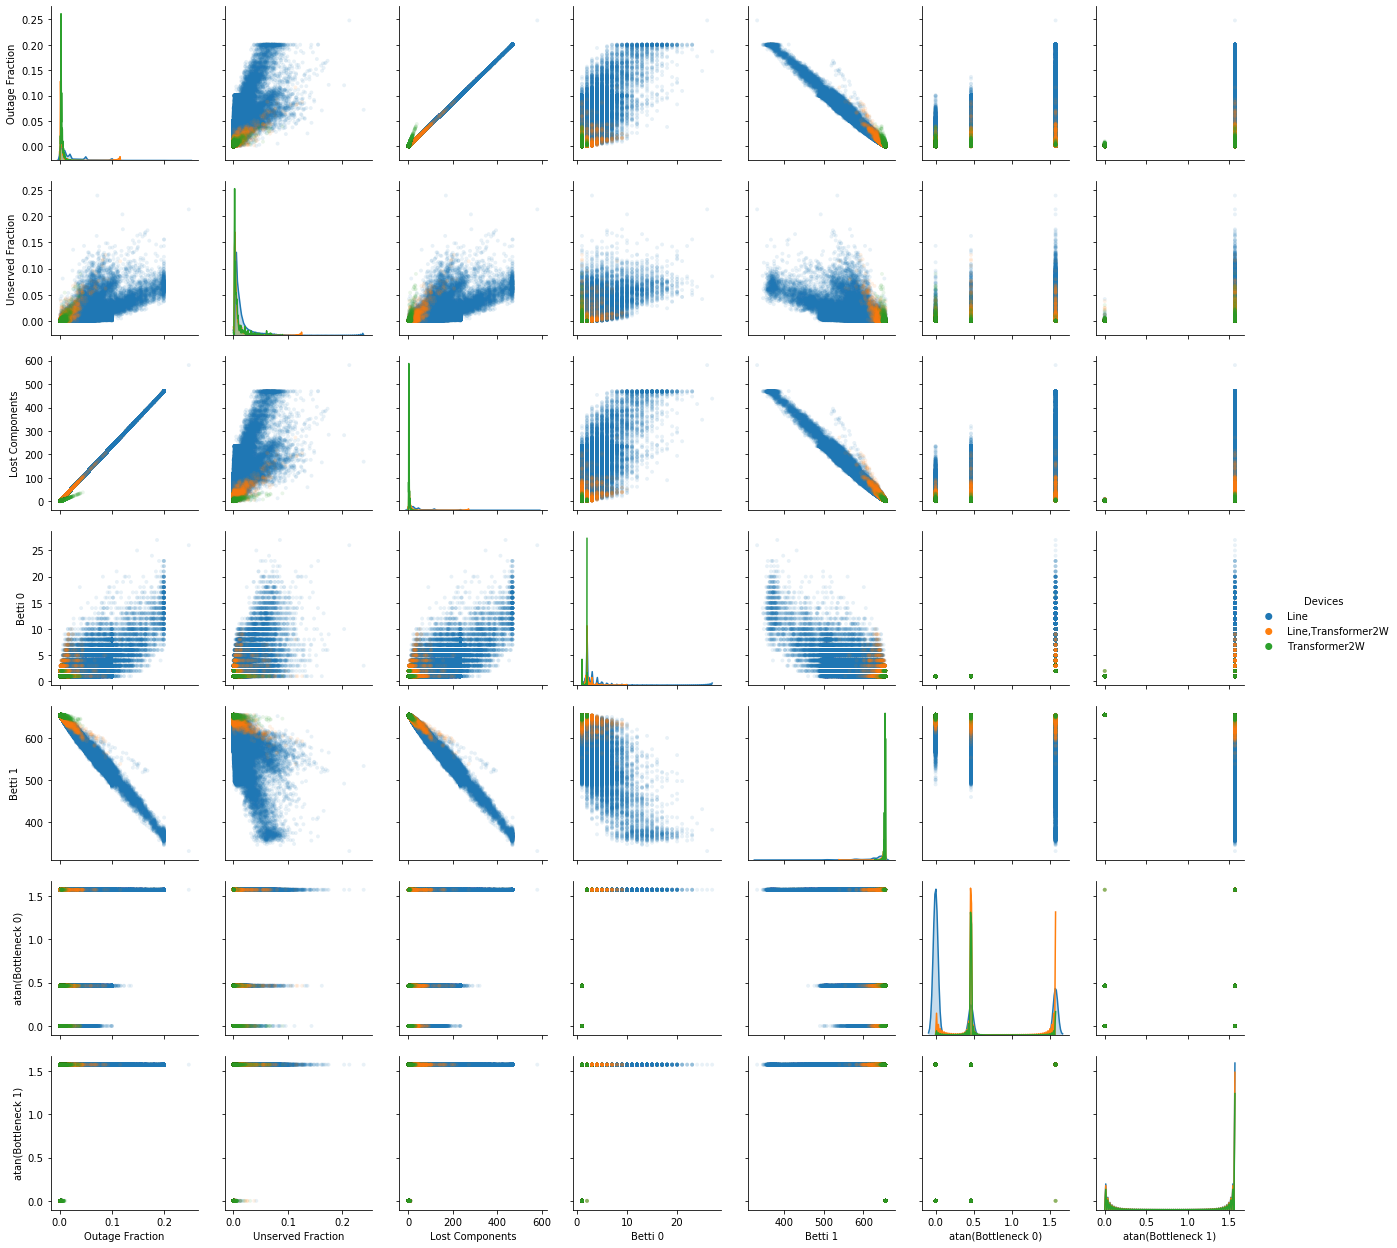

In [8]:
g = pairplot("Unweighted", "Unweighted Loss", "Lost Components", None)

In [9]:
g.savefig("pairs-unweighted.png")

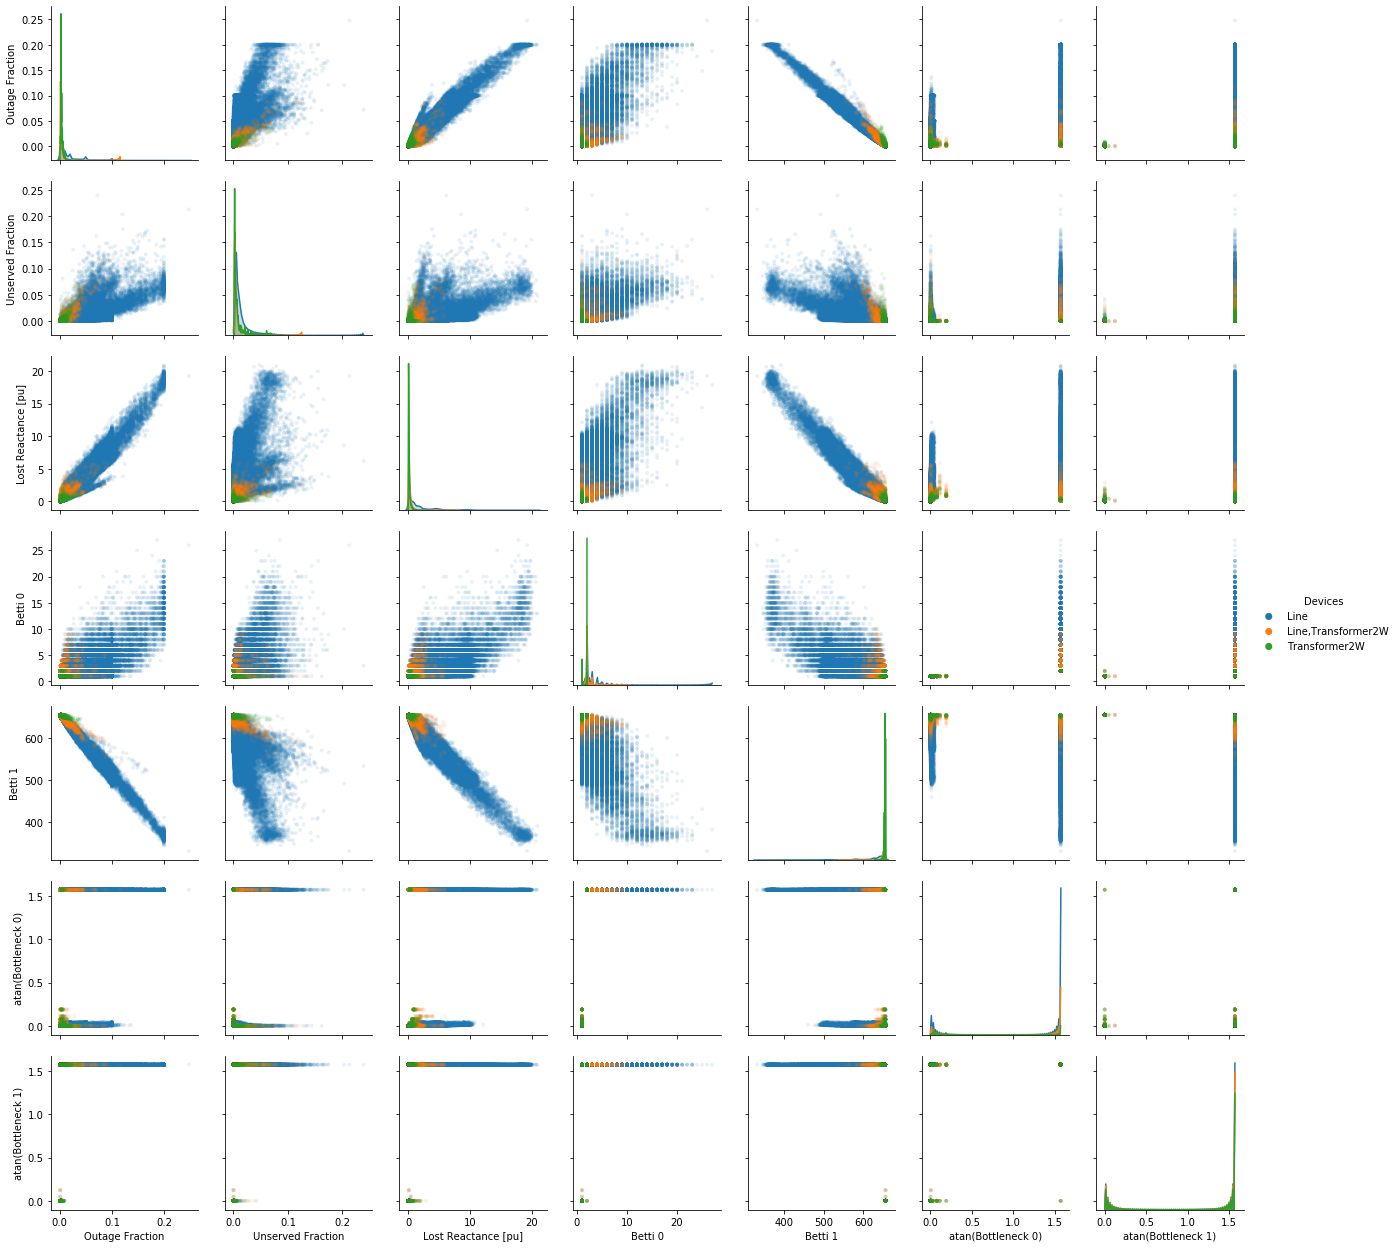

In [10]:
g = pairplot("Reactance", "Reactance Loss pu", "Lost Reactance [pu]", None)

In [11]:
g.savefig("pairs-reactance.png")

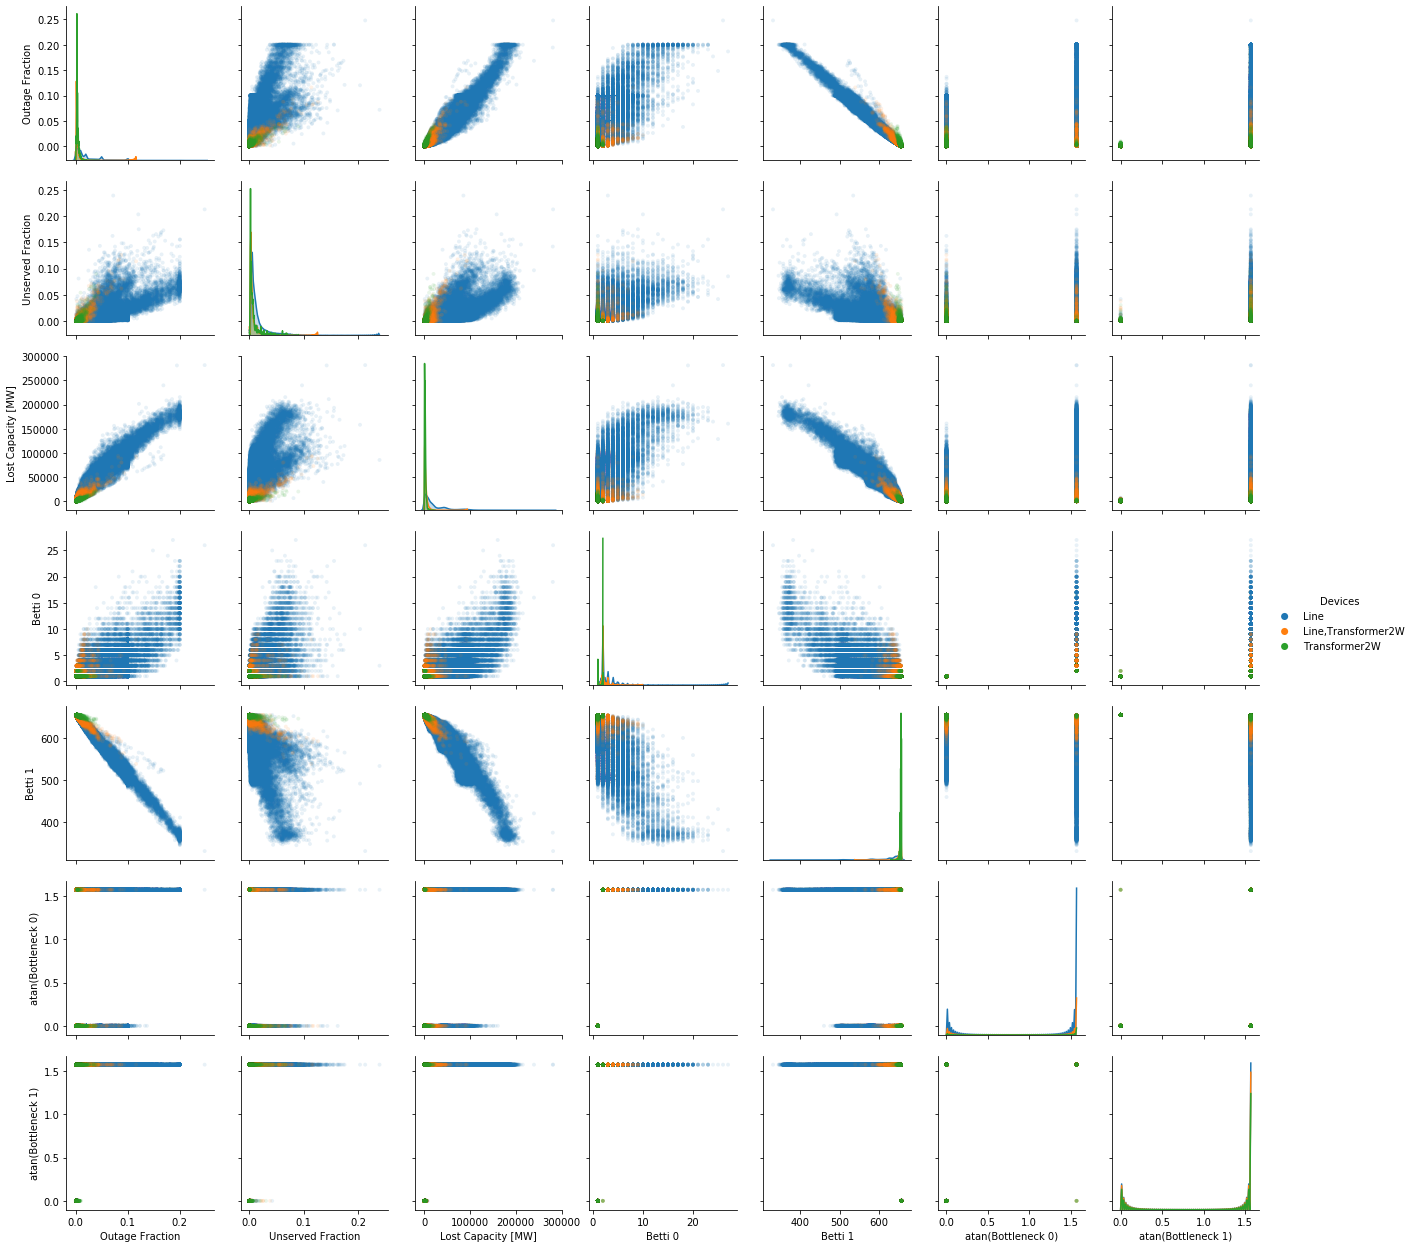

In [12]:
g = pairplot("Capacity", "Capacity Loss MW", "Lost Capacity [MW]", None)

In [13]:
g.savefig("pairs-capacity.png")

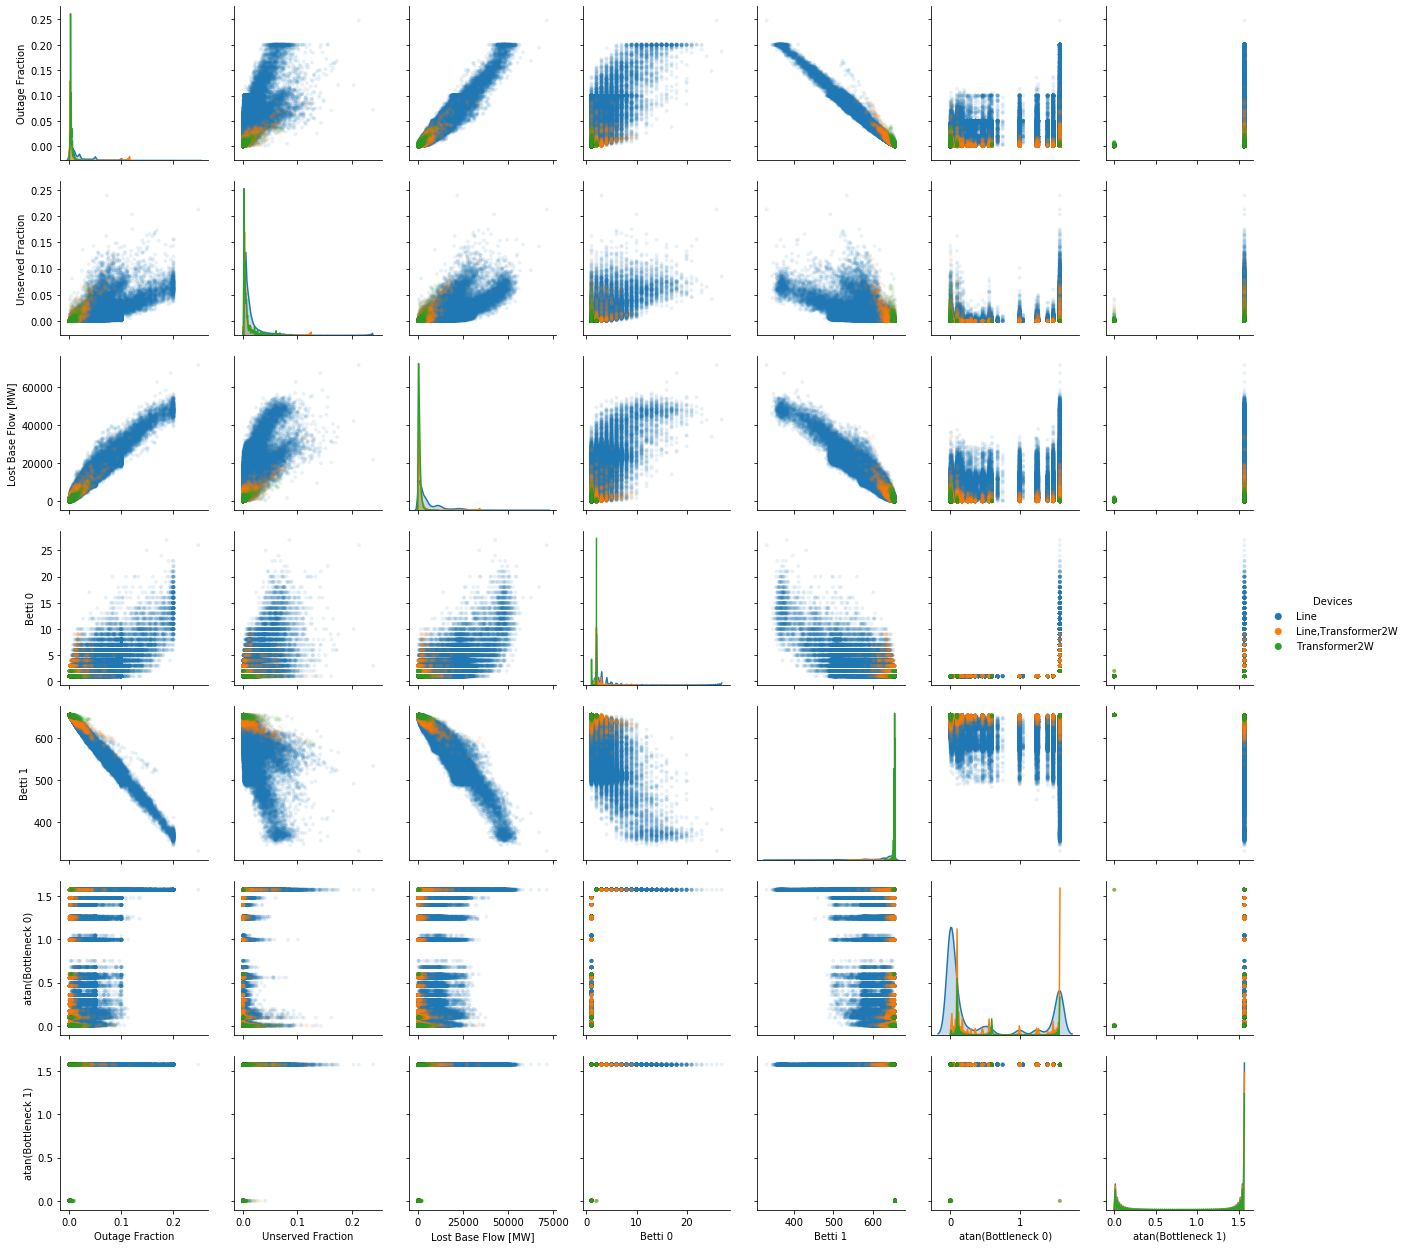

In [14]:
g = pairplot("Flow", "Flow Loss MW", "Lost Base Flow [MW]", None)

In [15]:
g.savefig("pairs-flow.png")

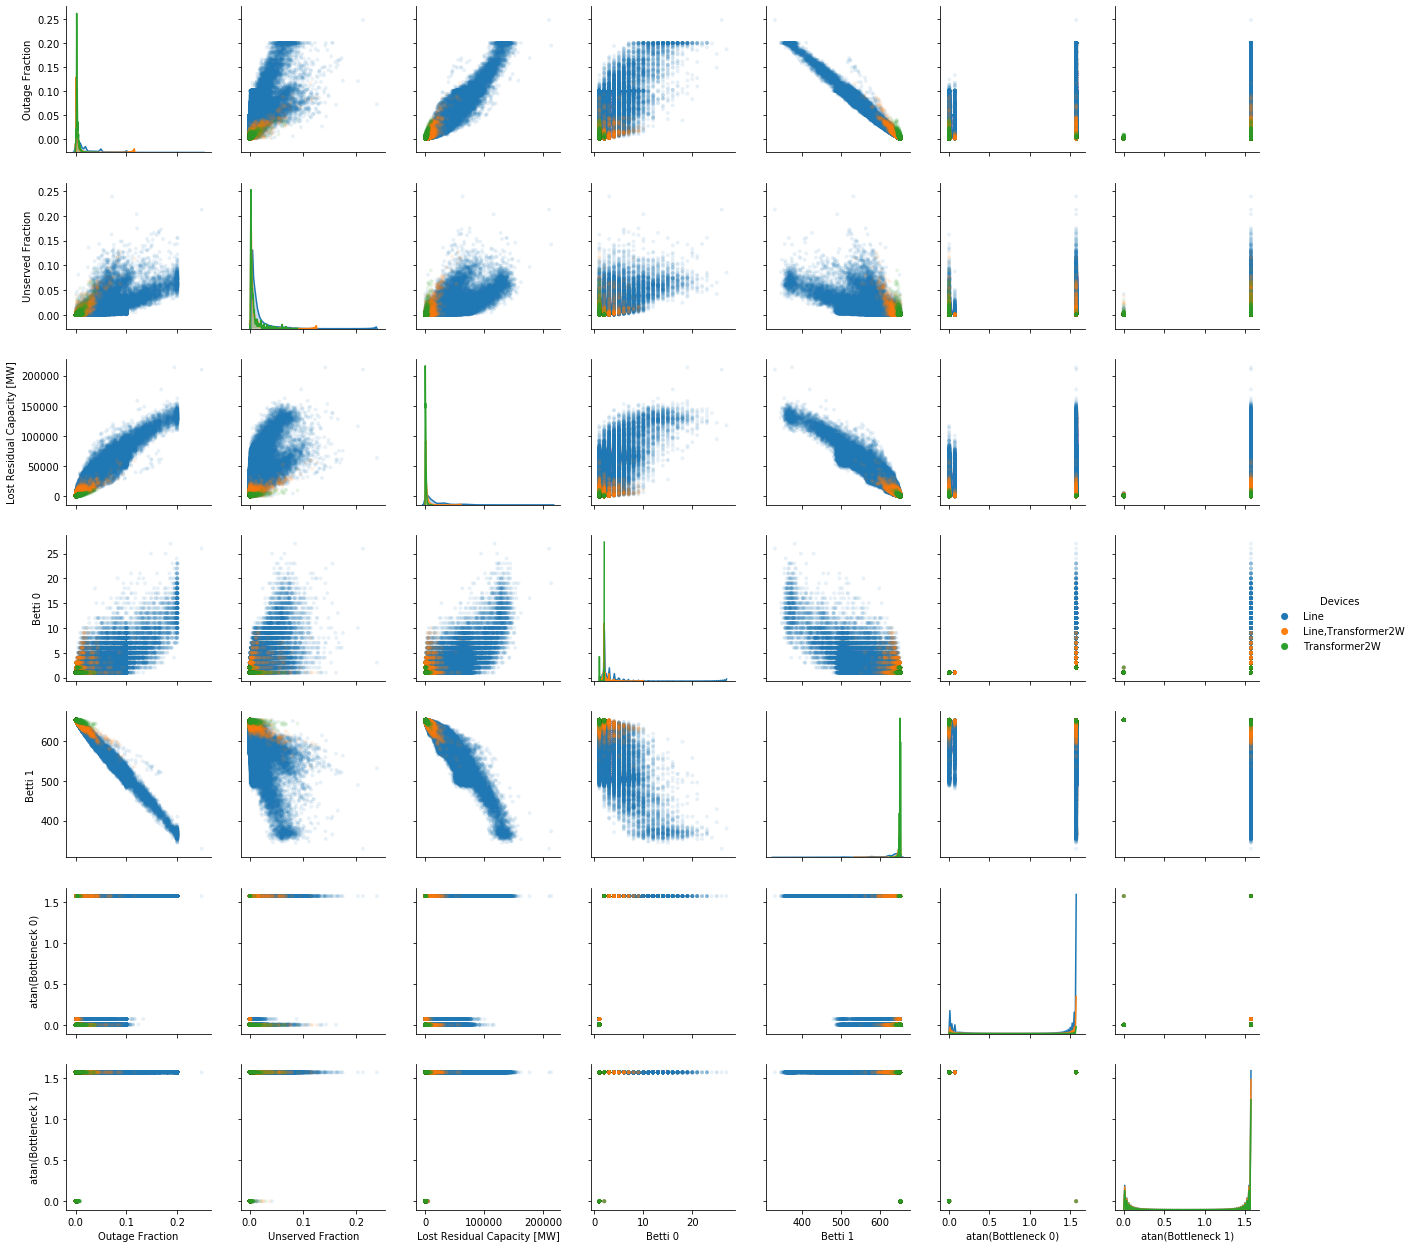

In [16]:
g = pairplot("Residue", "Residue Loss MW", "Lost Residual Capacity [MW]", None)

In [17]:
g.savefig("pairs-residue.png")

#### Losses.

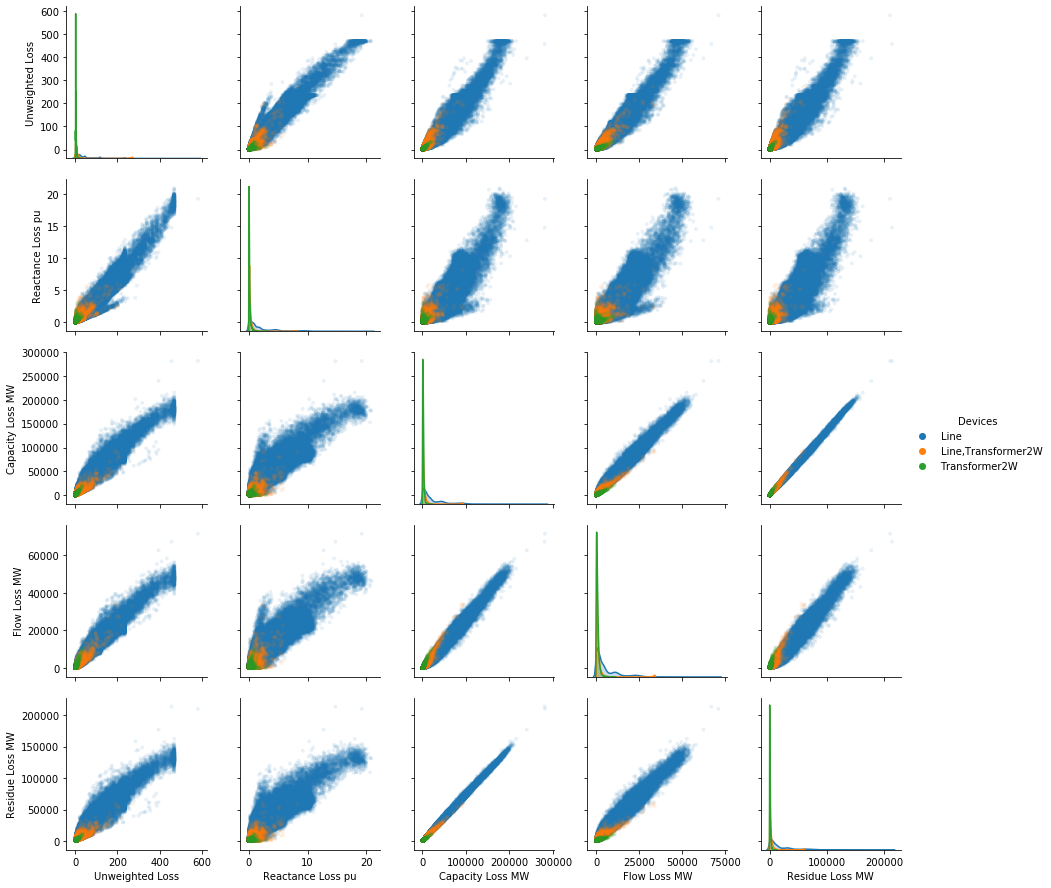

In [33]:
g = sb.pairplot(
    data = z,
    vars = [
        "Unweighted Loss",
        "Reactance Loss pu",
        "Capacity Loss MW",
        "Flow Loss MW",
        "Residue Loss MW",
    ],
    hue = "Devices",
    plot_kws = {
        "s"         : 15    ,
        "alpha"     : 0.1   ,
        "edgecolor" : "none",
    },
)
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50]
g.savefig("losses.png")

### Histograms.

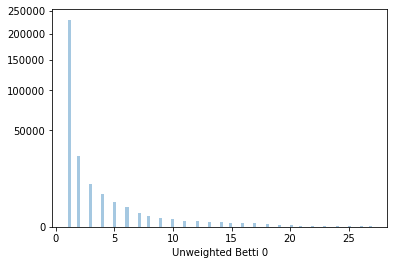

In [25]:
g = sb.distplot(
    z["Unweighted Betti 0"],
    kde = False,
#   rug = True,
    bins  = 100,
)
g.set_yscale("squareroot")
g.get_figure().savefig("unweighted-betti-0.png")

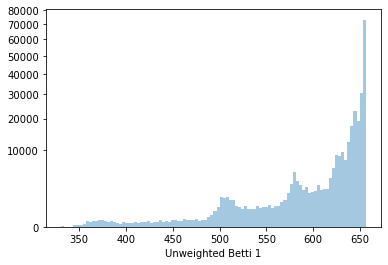

In [26]:
g = sb.distplot(
    z["Unweighted Betti 1"],
    kde = False,
#   rug = True,
    bins  = 100,
)
g.set_yscale("squareroot")
g.get_figure().savefig("unweighted-betti-1.png")

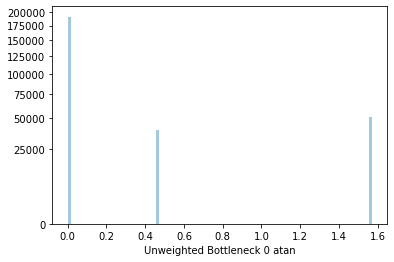

In [27]:
g = sb.distplot(
    z["Unweighted Bottleneck 0 atan"],
    kde = False,
#   rug = True,
    bins  = 100,
)
g.set_yscale("squareroot")
g.get_figure().savefig("unweighted-bottleneck-0.png")

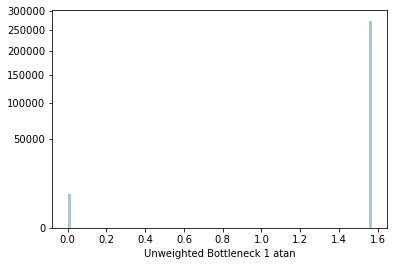

In [28]:
g = sb.distplot(
    z["Unweighted Bottleneck 1 atan"],
    kde = False,
#   rug = True,
    bins  = 100,
)
g.set_yscale("squareroot")
g.get_figure().savefig("unweighted-bottleneck-1.png")

## Fits.

### Sets of factors.

In [35]:
sets = [
    [                     "Unweighted Betti 0", "Unweighted Betti 1", "Unweighted Bottleneck 0 atan", "Unweighted Bottleneck 1 atan"],
    ["Unweighted Loss"  , "Unweighted Betti 0", "Unweighted Betti 1", "Unweighted Bottleneck 0 atan", "Unweighted Bottleneck 1 atan"],
    [                     "Reactance Betti 0" , "Reactance Betti 1" , "Reactance Bottleneck 0 atan" , "Reactance Bottleneck 1 atan" ],
    ["Reactance Loss pu", "Reactance Betti 0" , "Reactance Betti 1" , "Reactance Bottleneck 0 atan" , "Reactance Bottleneck 1 atan" ],
    [                     "Capacity Betti 0"  , "Capacity Betti 1"  , "Capacity Bottleneck 0 atan"  , "Capacity Bottleneck 1 atan"  ],
    ["Capacity Loss MW" , "Capacity Betti 0"  , "Capacity Betti 1"  , "Capacity Bottleneck 0 atan"  , "Capacity Bottleneck 1 atan"  ],
    [                     "Flow Betti 0"      , "Flow Betti 1"      , "Flow Bottleneck 0 atan"      , "Flow Bottleneck 1 atan"      ],
    ["Flow Loss MW"     , "Flow Betti 0"      , "Flow Betti 1"      , "Flow Bottleneck 0 atan"      , "Flow Bottleneck 1 atan"      ],
    [                     "Residue Betti 0"   , "Residue Betti 1"   , "Residue Bottleneck 0 atan"   , "Residue Bottleneck 1 atan"   ],
    ["Residue Loss MW"  , "Residue Betti 0"   , "Residue Betti 1"   , "Residue Bottleneck 0 atan"   , "Residue Bottleneck 1 atan"   ],
]
suffixes = [
    [],
    ["Involves Line", "Involves Transformer"],
    ["Radius", "Fraction"],
    ["Outage Fraction"],
    ["Radius", "Fraction", "Outage Fraction"],
    ["Involves Line", "Involves Transformer", "Radius", "Fraction"],
    ["Involves Line", "Involves Transformer", "Outage Fraction"],
    ["Involves Line", "Involves Transformer", "Radius", "Fraction", "Outage Fraction"],
]
trials = [
    set + suffix
    for suffix in suffixes
    for set    in sets
]
len(trials)

80

### Training and testing sets.

In [38]:
z_sample = (z.copy() if True else z.sample(20000)).drop(columns = [
    'Devices'                , 'Outage Count'           ,
    'Served MW'              , 'Unserved Fraction'      ,
    'Reactance Bottleneck 0' , 'Reactance Bottleneck 1' ,
    'Capacity Bottleneck 0'  , 'Capacity Bottleneck 1'  , 
    'Flow Bottleneck 0'      , 'Flow Bottleneck 1'      ,
    'Residue Bottleneck 0'   , 'Residue Bottleneck 1'   ,
    'Unweighted Bottleneck 0', 'Unweighted Bottleneck 1',
])

scaler = MinMaxScaler().fit(z_sample.values)
z_sample = pd.DataFrame(
    scaler.transform(z_sample.values),
    columns=z_sample.columns,
    index=z_sample.index,
)
X = z_sample
y = z_sample[["Has Unserved", "Unserved MW"]]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size   = 0.3,
    random_state= 0  ,
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((196891, 32), (84382, 32), (196891, 2), (84382, 2))

### Classification.

In [21]:
def classify(
    name                    ,
    model                   ,
    X_train = X_train       ,
    y_train = y_train       ,
    X_test  = X_test        ,
    y_test  = y_test        ,
    trials  = trials        ,
    metric  = "Has Unserved",
    verbose = False         ,
):
    results = None
    for trial in trials:
        if verbose:
            print(trial)
        fit = model.fit(X_train[trial], y_train[metric])
        score = fit.score(X_test[trial], y_test[metric])
        confusion = confusion_matrix(y_test[metric], model.predict(X_test[trial]))
        confusion = confusion / confusion.sum()
        results = pd.DataFrame({
            "Model"           : [name]                                         ,
            "Weighting"       : re.sub(r" .*$", "", trial[0])                  ,
            "Devices"         : any(["Involves" in factor for factor in trial]),
            "Loss"            : any(["Loss"     in factor for factor in trial]),
            "Radius"          : "Radius"          in trial                     ,
            "Fraction"        : "Fraction"        in trial                     ,
            "Outage Fraction" : "Outage Fraction" in trial                     ,
            "Score"           : score                                          ,
            "True Positive"   : confusion[1,1]                                 ,
            "True Negative"   : confusion[0,0]                                 ,
            "False Positive"  : confusion[0,1]                                 ,
            "False Negative"  : confusion[1,0]                                 ,
        }).append(results)
    return results.reset_index(drop = True)

#### Linear SVM.

In [22]:
class_linsvm = classify(
    "Linear SVM",
    svm.SVC(
        kernel   = "linear",
#       max_iter = 1000000 ,
    ),
    verbose = False,
)
class_linsvm.Score.max()

0.8765850536844351

#### RDF SVM.

In [23]:
class_rbfsvm = classify(
    "RBF SVM",
    svm.SVC(
        kernel   = "rbf"  ,
        gamma    = "auto" ,
#       max_iter = 1000000,
    ),
)
class_rbfsvm.Score.max()

0.8774383162285796

#### CART.

In [24]:
class_tree = classify(
    "CART",
    DecisionTreeClassifier(
        criterion = "entropy",
        max_depth = 5,
#       min_samples_leaf = 1000,
    ),
)
class_tree.Score.max()

0.8833044962195729

#### Logistic regression.

In [25]:
class_logit = classify(
    "Logistic",
    LogisticRegression(
        solver = "lbfgs",
        max_iter = 1000,
    ),
)
class_logit.Score.max()

0.8788485696001517

#### Random forest.

In [26]:
class_forest = classify(
    "Random Forest",
    RandomForestClassifier(
        max_depth = 5,
        n_estimators = 10,
        max_features = 1,
    ),
)
class_forest.Score.max()

0.8822971723827356

#### ANN.

In [27]:
class_ann = classify(
    "ANN",
    MLPClassifier(
        alpha = 1,
        max_iter = 2500,
    ),
    verbose = False,
)
class_ann.Score.max()

0.8724253987817308

#### Combine and store classifications.

In [28]:
all_class = pd.concat([
    class_ann   ,
    class_forest,
    class_linsvm,
    class_rbfsvm,
    class_tree  ,
]).reset_index(drop=True).set_index([
    "Weighting"      ,
    "Devices"        ,
    "Loss"           ,
    "Radius"         ,
    "Fraction"       ,
    "Outage Fraction",
    "Model"          ,
]).sort_index()
all_class.to_csv("all_class.tsv", sep = "\t")
all_class.shape

(400, 5)

In [29]:
all_class[all_class.Score == all_class.Score.max()]

,,,,,,,Score,True Positive,True Negative,False Positive,False Negative
Weighting,Devices,Loss,Radius,Fraction,Outage Fraction,Model,,,,,
Unweighted,True,True,True,True,True,CART,0.883304,0.354045,0.52926,0.024235,0.09246


In [30]:
if False:
    with pd.option_context("display.max_rows", 1000):
        display(all_class)

#### Plot classifications.

In [34]:
all_class1 = all_class.copy()
all_class1["Sensitivity"] = all_class1["True Positive"] / (all_class1["True Positive"] + all_class1["False Negative"])
all_class1["Specificity"] = all_class1["True Negative"] / (all_class1["True Negative"] + all_class1["False Positive"])
def f(x):
    y = "Topology"
    if x["Radius"]:
        y += " + Graph"
    if x["Loss"] or x["Devices"]:
        y += " + Electrical"
    return y
all_class1["Factors"] = all_class1.reset_index().apply(f, axis = 1).values

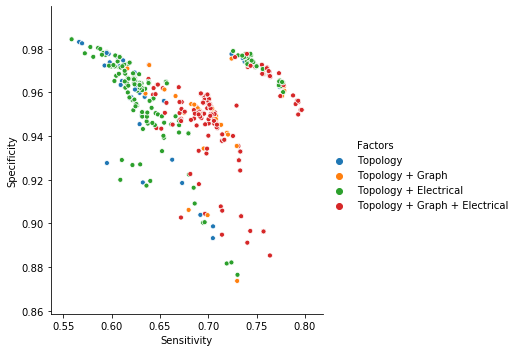

In [35]:
g = sb.relplot(
    data      = all_class1.reset_index(),
    x         = "Sensitivity",
    y         = "Specificity",
    hue       = "Factors"    ,
    s         = 25           ,
#   alpha     = 0.75         ,
#   edgecolor = "none"       ,
)

In [37]:
g.savefig("class-factors.png")

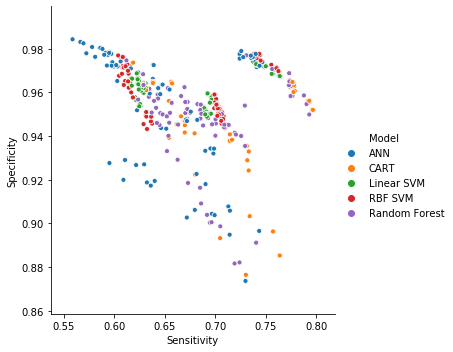

In [38]:
g = sb.relplot(
    data = all_class1.reset_index(),
    x = "Sensitivity",
    y = "Specificity",
    hue = "Model",
    s         = 25           ,
#   alpha     = 0.75         ,
#   edgecolor = "none"       ,
)

In [39]:
g.savefig("class-model.png")

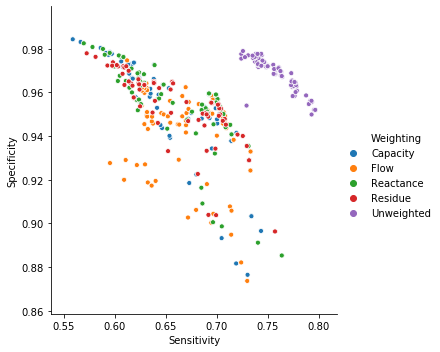

In [40]:
g = sb.relplot(
    data = all_class1.reset_index(),
    x = "Sensitivity",
    y = "Specificity",
    hue = "Weighting",
    s         = 25           ,
#   alpha     = 0.75         ,
#   edgecolor = "none"       ,
)

In [41]:
g.savefig("class-weighting.png")

#### CART example.

In [139]:
trial = sets[0]# + sets[2] + sets[4] + sets[6] + sets[8]
trial

['Unweighted Betti 0',
 'Unweighted Betti 1',
 'Unweighted Bottleneck 0 atan',
 'Unweighted Bottleneck 1 atan']

In [146]:
model = DecisionTreeClassifier(
#    criterion = "entropy",
#   max_depth = 3,
    max_leaf_nodes = 7,
#   min_samples_leaf = 1000,
)
fit = model.fit(X_train[trial], y_train["Has Unserved"])

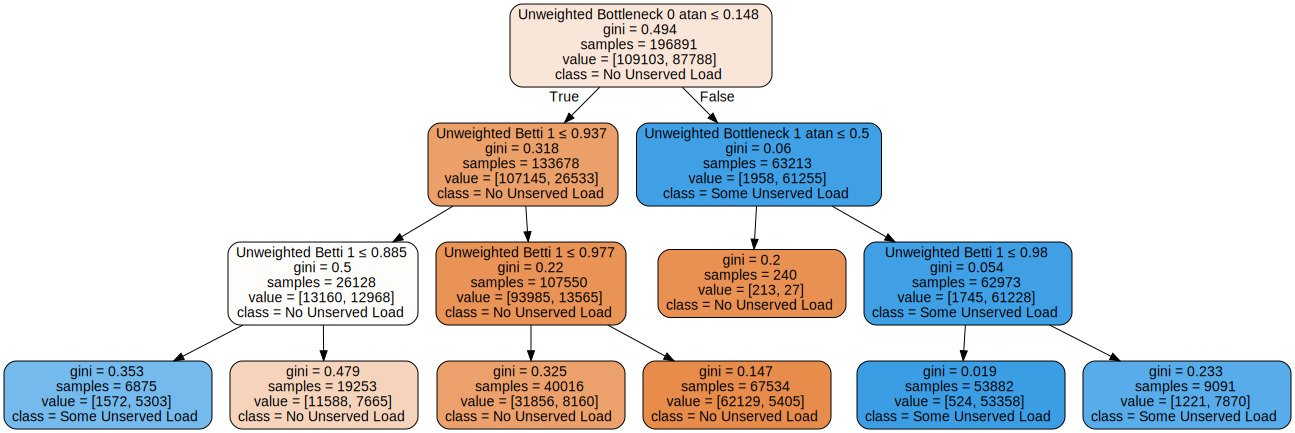

In [147]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(fit, out_file=None, 
                     feature_names=trial,  
                     class_names=["No Unserved Load", "Some Unserved Load"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data, format="png")  
graph.render(filename="cart.png")
graph

In [126]:
y_train["Has Unserved"].sum()

87788.0

### Regression.

In [42]:
def regress(
    name                   ,
    model                  ,
    X_train = X_train      ,
    y_train = y_train      ,
    X_test  = X_test       ,
    y_test  = y_test       ,
    trials  = trials       ,
    metric  = "Unserved MW",
    verbose = False        ,
):
    results = None
    for trial in trials:
        if verbose:
            print(trial)
        fit = model.fit(X_train[trial], y_train[metric])
        score = fit.score(X_test[trial], y_test[metric])
        results = pd.DataFrame({
            "Model"           : [name]                                         ,
            "Weighting"       : re.sub(r" .*$", "", trial[0])                  ,
            "Devices"         : any(["Involves" in factor for factor in trial]),
            "Loss"            : any(["Loss"     in factor for factor in trial]),
            "Radius"          : "Radius"          in trial                     ,
            "Fraction"        : "Fraction"        in trial                     ,
            "Outage Fraction" : "Outage Fraction" in trial                     ,
            "Score"           : score                                          ,
        }).append(results)
    return results.reset_index(drop = True)

#### OLS.

In [43]:
regress_ols = regress(
    "OLS",
    LinearRegression(
    ),
)
regress_ols.Score.max()

0.7061636836993913

#### ANN.

In [44]:
regress_ann = regress(
    "ANN",
    MLPRegressor(
        max_iter = 2500,
    ),
    verbose = False,
)
regress_ann.Score.max()

0.8730847053610168

#### Combine and store regressions.

In [45]:
all_regress = pd.concat([
    regress_ann,
    regress_ols,
]).reset_index(drop=True).set_index([
    "Weighting"      ,
    "Devices"        ,
    "Loss"           ,
    "Radius"         ,
    "Fraction"       ,
    "Outage Fraction",
    "Model"          ,
]).sort_index()
all_regress.to_csv("all_regress.tsv", sep = "\t")
all_regress.shape

(160, 1)

In [46]:
all_regress.Score.max()

0.8730847053610168

In [47]:
if False:
    with pd.option_context("display.max_rows", 1000):
        display(all_regress)

#### Plot regressions.

In [48]:
all_regress1 = all_regress.copy()
def f(x):
    y = "Topology"
    if x["Radius"]:
        y += " + Graph"
    if x["Loss"] or x["Devices"]:
        y += " + Electrical"
    return y
all_regress1["Factors"] = all_regress1.reset_index().apply(f, axis = 1).values

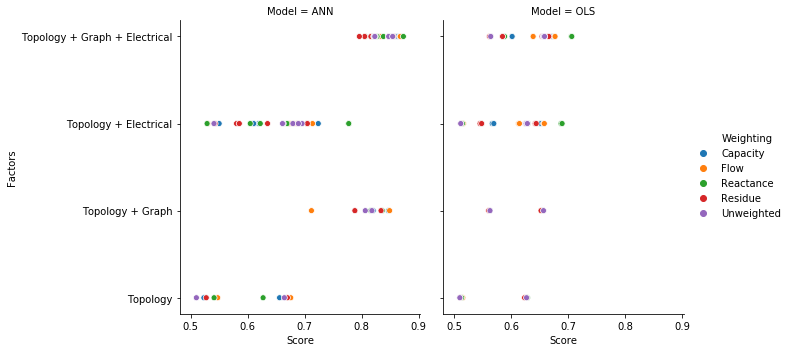

In [49]:
g = sb.relplot(
    data = all_regress1.reset_index(),
    y = "Factors",
    x = "Score",
    hue = "Weighting",
    col = "Model",
)

In [50]:
g.savefig("regress-weighting-model.png")

### Visualize residuals for ANN.

In [51]:
trials[73]

['Reactance Loss pu',
 'Reactance Betti 0',
 'Reactance Betti 1',
 'Reactance Bottleneck 0 atan',
 'Reactance Bottleneck 1 atan',
 'Involves Line',
 'Involves Transformer',
 'Radius',
 'Fraction',
 'Outage Fraction']

In [52]:
model = MLPRegressor(
    max_iter = 2500,
)
fit = model.fit(X_train[trials[73]], y_train["Unserved MW"])

Text(0, 0.5, 'Predicted Unserved Load [GW]')

/nix/store/f9jr3lh0ix952h7lr0xiwq9gkl1yckk1-python3-3.6.9-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


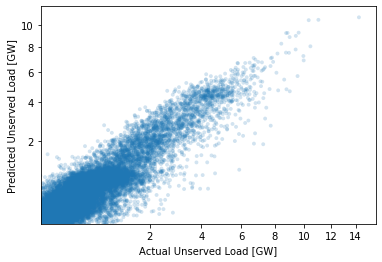

In [53]:
g = sb.scatterplot(
    x = y_test["Unserved MW"]           / scaler.scale_[3] / 1000,
    y = fit.predict(X_test[trials[73]]) / scaler.scale_[3] / 1000,
#    hue = X_test["Involves Transformer"],
    s         = 15           ,
    alpha     = 0.20         ,
    edgecolor = "none"       ,
)
g.set_xscale("squareroot")
g.set_yscale("squareroot")
g.set_xlabel("Actual Unserved Load [GW]")
g.set_ylabel("Predicted Unserved Load [GW]")

In [54]:
g.get_figure().savefig("regress-residuals.png")

/nix/store/f9jr3lh0ix952h7lr0xiwq9gkl1yckk1-python3-3.6.9-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt
